### Overview 
As a top-tier tech company, Apple boasts a robust portfolio from smartphones such as the iPhone, tablets like the iPad, laptops like the MacBook, and wearables like the Apple Watch. Its products elicit strong hunger among consumers and chatter on social media. Track Sentiment on Social Media To Help Address Customer Concerns Content With The Apple Experience Social media analysis helps companies comprehend the perception of their audience such that it is possible to offer insights for improvement of services or commodity. Sentiment Analysis of Apple on Social Media Overview: This project analyzes sentiment around Apple on social media, paying particular attention to popular topics, recurring issues, and methods to extract sentiment. This helps us to determine which analysis techniques work better, which product aspects are dominating the discussions and what are the stakeholders frustrations.

## CLEANING DATA

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer

In [96]:
#Read the data 
df=pd.read_csv('Apple-Twitter-Sentiment-DFE.csv', encoding='latin1')

In [97]:
df['sentiment'].value_counts(
)

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [99]:
#check columns with missing vallues
df.isna().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        103
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3783
text                       0
dtype: int64

In [100]:
df.duplicated().value_counts()

False    3886
Name: count, dtype: int64

In [101]:
#drop columns with missing values
df.drop(columns=['_last_judgment_at', 'sentiment_gold'],inplace=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   sentiment             3886 non-null   object 
 5   sentiment:confidence  3886 non-null   float64
 6   date                  3886 non-null   object 
 7   id                    3886 non-null   float64
 8   query                 3886 non-null   object 
 9   text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 277.2+ KB


In [103]:
# create a copy of the df
df_clean=df.copy()

Most of the columns in the dataset are unnecessary as the labels provided were generated by a separate model, hence inapplicable to the work we are doing.

In [104]:
#Drop unnecessary columns
df_clean = df_clean[['text']]

In [105]:
# Checking for and removing duplicated tweets
df_clean.duplicated().value_counts()

False    3219
True      667
Name: count, dtype: int64

In [106]:
df_clean.drop_duplicates(inplace=True)

In [107]:
# The function below is used to clean the text, removing URLs, mentions, hashtags and other irrelevant pieces of text
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove RT (retweet) indicator
        text = re.sub(r'^RT\s+', '', text)
        # Remove multiple spaces and strip
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        text=text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation.replace('<', '').replace('>', '')))
    return text

In [108]:
# Apply cleaning to the 'text' column
df_clean['text'] = df_clean['text'].apply(clean_text)

In [109]:
print("Before cleaning:")
print(df['text'].head())
print("\
After cleaning:")
print(df_clean['text'].head())

Before cleaning:
0    #AAPL:The 10 best Steve Jobs emails ever...htt...
1    RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2    My cat only chews @apple cords. Such an #Apple...
3    I agree with @jimcramer that the #IndividualIn...
4         Nobody expects the Spanish Inquisition #AAPL
Name: text, dtype: object
After cleaning:
0                   the 10 best steve jobs emails ever
1      why aapl stock had a miniflash crash today aapl
2                     my cat only chews cords such an 
3    i agree with that the should own not trade  it...
4               nobody expects the spanish inquisition
Name: text, dtype: object


In [110]:
# Upon cleaning the text duplicated tweets appear yet again
df_clean.duplicated().value_counts()

False    3027
True      192
Name: count, dtype: int64

In [111]:
# These seem to be duplicated tweets that can be dropped as they do not represent a mass tweeting campaign.
df_clean[df_clean.duplicated() == True]

,text
36,apple inc flash crash what you need to know
237,apples pt raised by canaccord genuity to 13500...
293,apple fibonacci technicals levels intraday u...
309,apple fibonacci technicals levels intraday u...
326,apple fibonacci technicals levels intraday u...
...,...
3871,apple is warming up to social media apple is h...
3873,apple is warming up to social media apple is h...
3874,apple is warming up to social media apple is h...
3875,apple is warming up to social media apple is h...


In [112]:
df_clean.drop_duplicates(inplace=True)

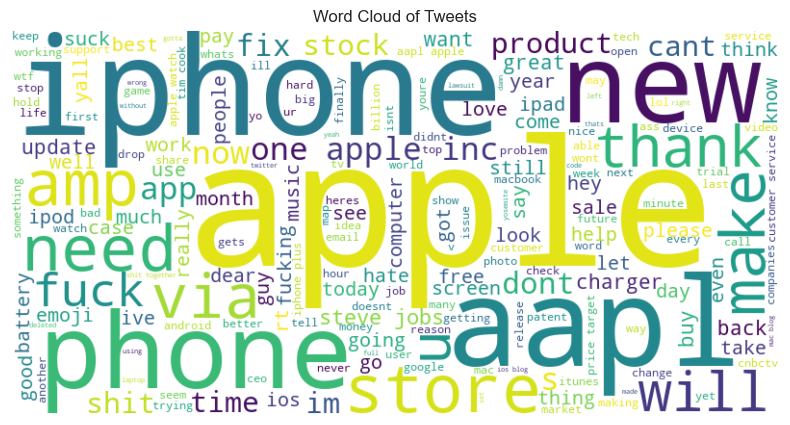

In [113]:
from wordcloud import WordCloud
# Generate Word Cloud
text = ' '.join(df_clean['text'])  # Combine all text into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Tweets')
plt.show()

This word cloud visually summarizes the most common words from tweets, offering insights into
What people are talking about most frequently when discussing Apple,
Themes or topics that are top-of-mind for users and 
Possible areas of focus for sentiment analysis or further investigation into user concerns and perceptions.

### Sentiment analysis
Sentiment analysis is a natural language processing (NLP) technique used to determine the emotional tone behind a series of words. This document demonstrates how to perform sentiment analysis on a set of tweets using NLTK's `SentimentIntensityAnalyzer`.

In [114]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon for NLTK
nltk.download('vader_lexicon')


# Initializing SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment using NLTK's SentimentIntensityAnalyzer
def get_nltk_sentiment(tweet):
    score = sia.polarity_scores(tweet)
    return score['compound']  # Returns a value between -1 and 1 (-1 being negative and 1 being)

# Apply the function to the df_clean
df_clean['nltk_sentiment'] = df_clean['text'].apply(get_nltk_sentiment)

# Display the DataFrame with sentiment scores
df_clean


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luwate/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,nltk_sentiment
0,the 10 best steve jobs emails ever,0.6369
1,why aapl stock had a miniflash crash today aapl,-0.4019
2,my cat only chews cords such an,0.0000
3,i agree with that the should own not trade it...,0.6597
4,nobody expects the spanish inquisition,-0.2960
...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404
3881,via fc apple is warming up to social media ap...,0.1531
3882,there is no avocado emoji may i ask why,-0.2960
3883,i could not agree more between and only great ...,0.4570


### Histogram combined with a kernel density estimate (KDE) plot & Bar chart

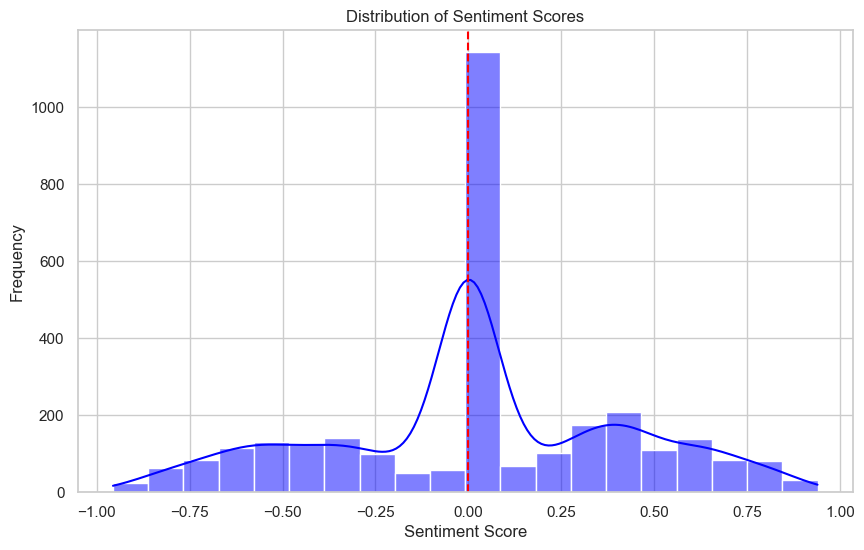

/var/folders/sh/s_xv2d8x6kv1_qyc9qgmkv300000gn/T/ipykernel_3353/2691307813.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


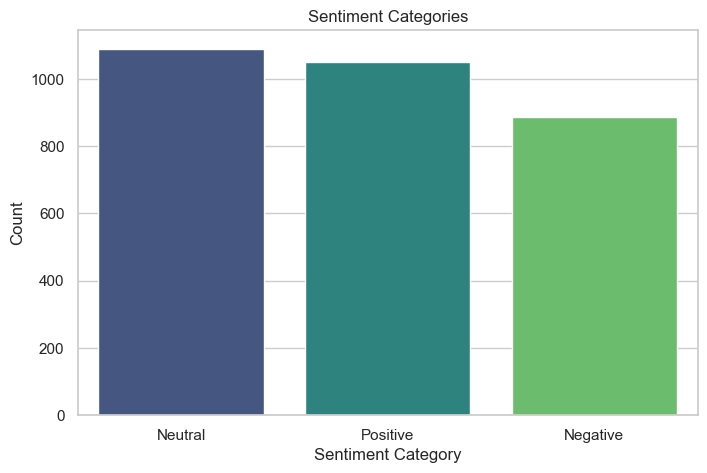

In [115]:

# Visualization

# Set the style of seaborn
sns.set(style="whitegrid")

# Histogram of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['nltk_sentiment'], bins=20, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line for neutral sentiment
plt.show()

# Categorizing sentiment scores
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_clean['sentiment_category'] = df_clean['nltk_sentiment'].apply(categorize_sentiment)

# Count the number of occurrences of each sentiment category
sentiment_counts = df_clean['sentiment_category'].value_counts()

# Bar chart for sentiment categories
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

The histogram shows us the distribution of the sentiment of tweets. The sentiment generally leans positive and this is supported by the bar chart which shows positive sentiment having more tweets than negative.

However in the histogram, there is a noticeable spike in texts classified with a score of between 0.3 and 0.45. Inspecting a sample of scores in this range reveals that there has been some mis-calssification of text, which may skew the results.

In order to attempt to combat this, we can attempt to make use of a different approach; specifically including TextBlob in the analysis process and a K-Means model, with 3 clusters (positive, negative and neutral)

In [116]:
df_clean[(df_clean['nltk_sentiment']>0.3) & (df_clean['nltk_sentiment']<0.45)].sample(15)

,text,nltk_sentiment,sentiment_category
2938,is that a chicfilet mug hes holding my daughte...,0.4019,Positive
1847,s stock on a tear due to higher profit margin ...,0.4404,Positive
369,when you cant hear people through your headpho...,0.3612,Positive
124,thank you,0.3612,Positive
1730,kantar worldpanel iphone sales in october wer...,0.3182,Positive
2204,12 unexpected stocks bringing buffett and fell...,0.4019,Positive
850,huge iphone 6 sales put apple on course for re...,0.3182,Positive
1151,true silly iphone get your life together,0.4404,Positive
3111,would you recommend buy the dips,0.3612,Positive
1344,i believe second or third my dear,0.3818,Positive


In [117]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply to the 'text' column
df_clean['blob_sentiment'] = df_clean['text'].apply(get_sentiment)

In [118]:
df_clean

,text,nltk_sentiment,sentiment_category,blob_sentiment
0,the 10 best steve jobs emails ever,0.6369,Positive,1.000000
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,0.000000
2,my cat only chews cords such an,0.0000,Neutral,0.000000
3,i agree with that the should own not trade it...,0.6597,Positive,0.650000
4,nobody expects the spanish inquisition,-0.2960,Negative,0.000000
...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,0.175000
3881,via fc apple is warming up to social media ap...,0.1531,Positive,0.022222
3882,there is no avocado emoji may i ask why,-0.2960,Negative,0.000000
3883,i could not agree more between and only great ...,0.4570,Positive,0.433333


In [119]:
df_clean['average_sentiment'] = (df_clean['nltk_sentiment'] + df_clean['blob_sentiment']) / 2

In [120]:
df_clean

,text,nltk_sentiment,sentiment_category,blob_sentiment,average_sentiment
0,the 10 best steve jobs emails ever,0.6369,Positive,1.000000,0.818450
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,0.000000,-0.200950
2,my cat only chews cords such an,0.0000,Neutral,0.000000,0.000000
3,i agree with that the should own not trade it...,0.6597,Positive,0.650000,0.654850
4,nobody expects the spanish inquisition,-0.2960,Negative,0.000000,-0.148000
...,...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,0.175000,0.307700
3881,via fc apple is warming up to social media ap...,0.1531,Positive,0.022222,0.087661
3882,there is no avocado emoji may i ask why,-0.2960,Negative,0.000000,-0.148000
3883,i could not agree more between and only great ...,0.4570,Positive,0.433333,0.445167


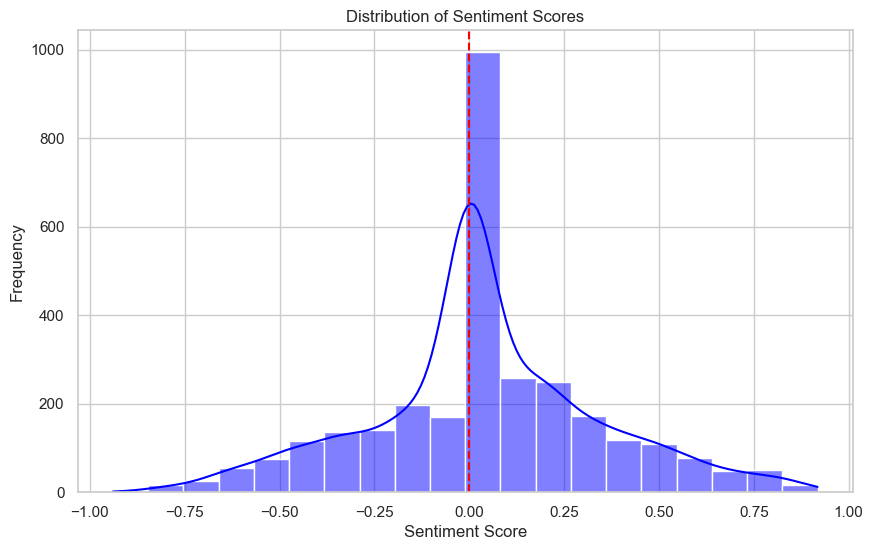

/var/folders/sh/s_xv2d8x6kv1_qyc9qgmkv300000gn/T/ipykernel_3353/1892704462.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


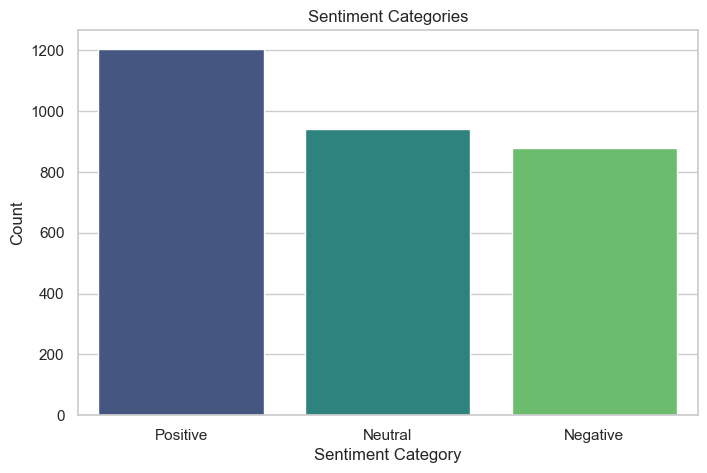

In [121]:

# Visualization

# Set the style of seaborn
sns.set(style="whitegrid")

# Histogram of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['average_sentiment'], bins=20, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line for neutral sentiment
plt.show()

# Categorizing sentiment scores
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_clean['sentiment_category'] = df_clean['average_sentiment'].apply(categorize_sentiment)

# Count the number of occurrences of each sentiment category
sentiment_counts = df_clean['sentiment_category'].value_counts()

# Bar chart for sentiment categories
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

The combination of TextBlob and VADER seems to change the results significantly with a much bigger proportion of tweets beong interpretd as positive.

Below a sample of the Positive tweets is taken and the different scores are evaluated. 

In [122]:
df_clean[df_clean['sentiment_category']=='Positive'].sample(10)

,text,nltk_sentiment,sentiment_category,blob_sentiment,average_sentiment
1395,new problem at airport boarding pass on phone ...,0.3182,Positive,0.136364,0.227282
1077,channels in a hilarious ad for its new catalo...,0.4019,Positive,0.318182,0.360041
2402,hey hundreds of black white brown yellow prot...,0.3875,Positive,-0.055556,0.165972
3728,apple again orders app developer to remove a u...,0.6908,Positive,0.450000,0.570400
496,results of our pilothouse program see which ha...,0.5256,Positive,0.416667,0.471133
2765,rt apple unveils new ipad air 2 ads via,0.0000,Positive,0.136364,0.068182
3726,loving the samsung one with kristen bell rt w...,0.5994,Positive,0.412121,0.505761
568,ultra red ok i have some research to do ive se...,0.2960,Positive,0.125000,0.210500
923,falling on your laptop creates s lateståêinnov...,0.1280,Positive,0.000000,0.064000
2597,lol quicktime movs,0.4215,Positive,0.800000,0.610750


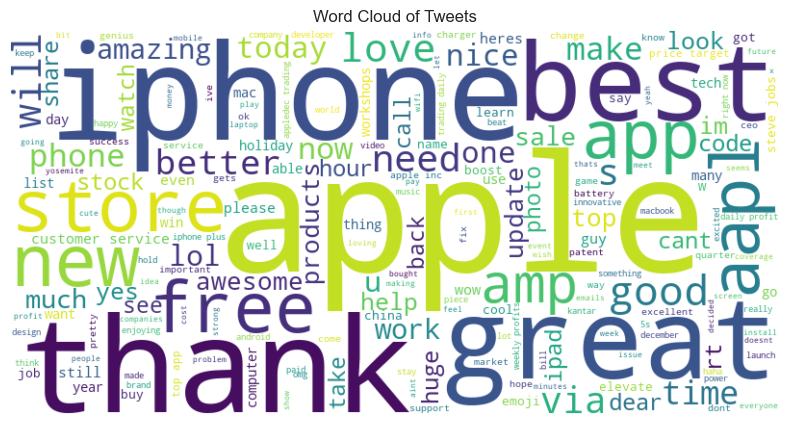

In [124]:
# Generate Word Cloud
text = ' '.join(df_clean[df_clean['average_sentiment'] > 0.3]['text'])  # Combine all text into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Tweets')
plt.show()

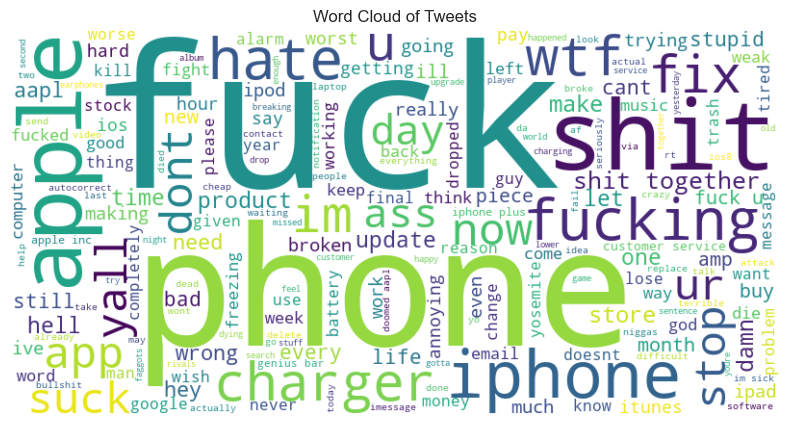

In [123]:
# Generate Word Cloud
text = ' '.join(df_clean[df_clean['average_sentiment'] < -0.3]['text'])  # Combine all text into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Tweets')
plt.show()

In [63]:
from nrclex import NRCLex

# Function to detect and extract the top emotion
def detect_top_emotion(text):
    emotion = NRCLex(text)
    if emotion.top_emotions:  # Check if there are detected emotions
        return emotion.top_emotions[0][0]  # Return the emotion with the highest score
    else:
        return None  # Return None if no emotion is detected

# Apply the function to the 'text' column
df_clean['top_emotion'] = df_clean['text'].apply(detect_top_emotion)


In [65]:
df_clean['top_emotion'].value_counts()

top_emotion
fear            1443
positive         557
trust            374
negative         281
anger            182
anticipation     130
surprise          45
sadness            9
joy                3
disgust            3
Name: count, dtype: int64

In [826]:
stopwords_list = set(stopwords.words('english')) - {'not', 'never'}
lemmatizer = WordNetLemmatizer()

In [827]:
def preprocess_text(text):
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords_list]
    return ' '.join(tokens)

df_clean['processed_text'] = df_clean['text'].apply(preprocess_text)

In [828]:
df_clean

,text,nltk_sentiment,sentiment_category,blob_sentiment,average_sentiment,processed_text
0,the 10 best steve jobs emails ever,0.6369,Positive,1.000000,0.818450,10 best steve job email ever
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,0.000000,-0.200950,aapl stock miniflash crash today aapl
2,my cat only chews cords such an,0.0000,Neutral,0.000000,0.000000,cat chew cord
3,i agree with that the should own not trade it...,0.6597,Positive,0.650000,0.654850,agree not trade extended today pullback good see
4,nobody expects the spanish inquisition,-0.2960,Negative,0.000000,-0.148000,nobody expects spanish inquisition
...,...,...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,0.175000,0.307700,hey normal laptop charger soldering skin thanks j
3881,via fc apple is warming up to social media ap...,0.1531,Positive,0.022222,0.087661,via fc apple warming social medium apple hirin...
3882,there is no avocado emoji may i ask why,-0.2960,Negative,0.000000,-0.148000,avocado emoji may ask
3883,i could not agree more between and only great ...,0.4570,Positive,0.433333,0.445167,could not agree great thing happen


/var/folders/sh/s_xv2d8x6kv1_qyc9qgmkv300000gn/T/ipykernel_76174/3882354597.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=tfidf_df, palette='Greens_d')


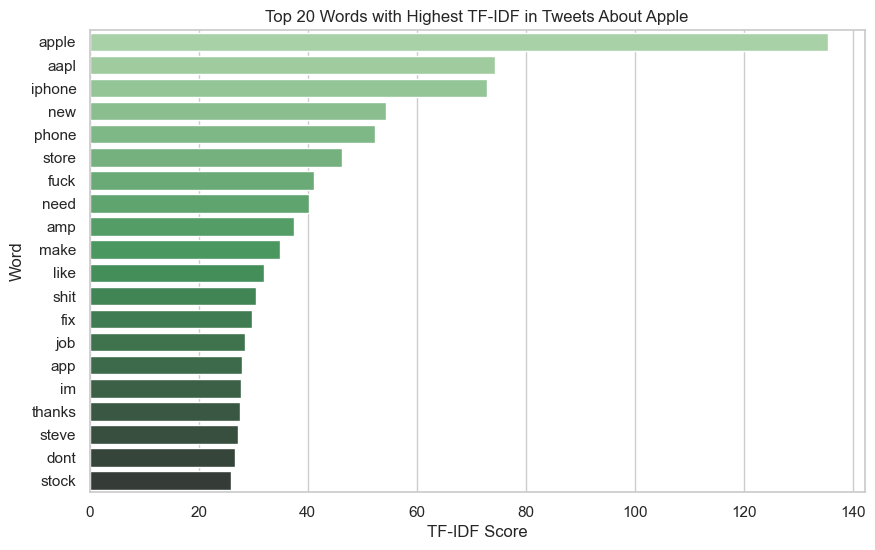

In [829]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Apply vectorizer to the text data
X = vectorizer.fit_transform(df_clean['processed_text'])

# Get the TF-IDF values
tfidf_scores = X.sum(axis=0).A1
tfidf_features = vectorizer.get_feature_names_out() 

# Create a DataFrame to store words and their TF-IDF scores
tfidf_df = pd.DataFrame({'word': tfidf_features, 'tfidf': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# Plot the top 20 words with the highest TF-IDF scores
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='word', data=tfidf_df, palette='Greens_d')
plt.title('Top 20 Words with Highest TF-IDF in Tweets About Apple')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.show()

The chart shows the most discussed topics, with higher bars indicating key focus areas like customer needs or product features, which can help prioritize user concerns.

In [830]:
from sklearn.cluster import KMeans

kmeans = KMeans(3, random_state=42)
clusters = kmeans.fit_predict(X)
df_clean['cluster'] = clusters

In [831]:
df_clean

,text,nltk_sentiment,sentiment_category,blob_sentiment,average_sentiment,processed_text,cluster
0,the 10 best steve jobs emails ever,0.6369,Positive,1.000000,0.818450,10 best steve job email ever,0
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,0.000000,-0.200950,aapl stock miniflash crash today aapl,1
2,my cat only chews cords such an,0.0000,Neutral,0.000000,0.000000,cat chew cord,0
3,i agree with that the should own not trade it...,0.6597,Positive,0.650000,0.654850,agree not trade extended today pullback good see,0
4,nobody expects the spanish inquisition,-0.2960,Negative,0.000000,-0.148000,nobody expects spanish inquisition,0
...,...,...,...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,0.175000,0.307700,hey normal laptop charger soldering skin thanks j,0
3881,via fc apple is warming up to social media ap...,0.1531,Positive,0.022222,0.087661,via fc apple warming social medium apple hirin...,1
3882,there is no avocado emoji may i ask why,-0.2960,Negative,0.000000,-0.148000,avocado emoji may ask,0
3883,i could not agree more between and only great ...,0.4570,Positive,0.433333,0.445167,could not agree great thing happen,0


In attempt to identify the clusters using the sentiment score obtained from VADER earlier, the histograms for each cluster are plotted

Expectation: Each cluster has a clear majority of tweets crowded around positive, negative or neutral.

<Axes: ylabel='Frequency'>

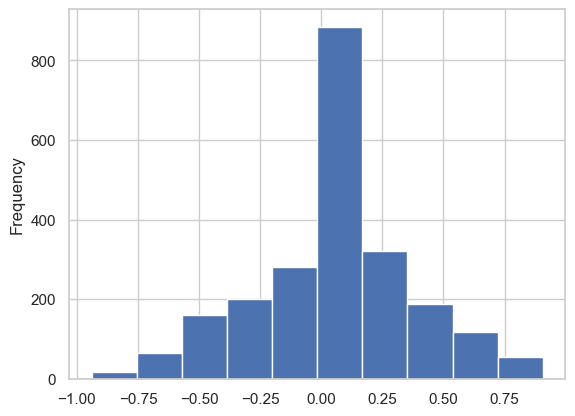

In [832]:
df_clean[df_clean['cluster'] == 0]['average_sentiment'].plot.hist()

<Axes: ylabel='Frequency'>

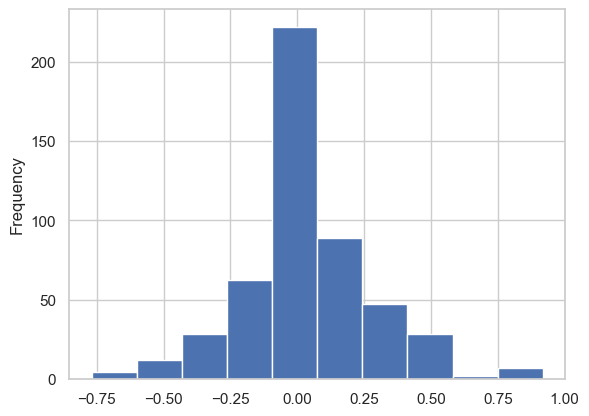

In [833]:
df_clean[df_clean['cluster'] == 1]['average_sentiment'].plot.hist()

<Axes: ylabel='Frequency'>

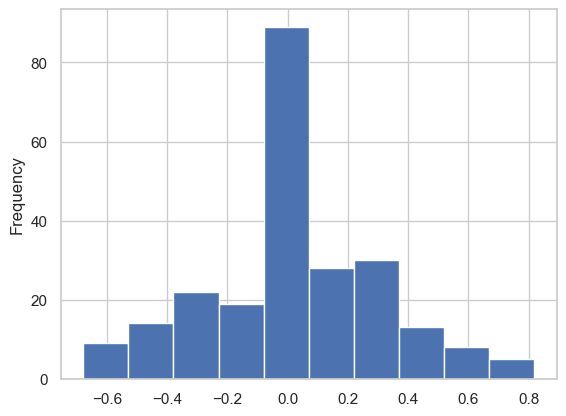

In [834]:
df_clean[df_clean['cluster'] == 2]['average_sentiment'].plot.hist()

The K-means model, evident by the lack of meaningful difference in distribution of average scores for each cluster seems to fail to cluster the tweets in a manner that is significantly better than what the vader model was able to do.

## Conclusions

The overall sentiment of apple leans positive. The most accurate sentiment analysis menthod is the combination of VADER and Blob. 

The most common topic seems to be the iPhone.

The frequent appearance of curse words suggests significant frustration among a group of stakeholders. This may be as individuals individuals tend to flock to twitter/X mainly when they face issues with the product